<div>
<img style="float: left;" src="assets/error_estimates_qrf/logo_MPG.png" width=150>
<img style="float: left; margin-top: -10px" src="assets/error_estimates_qrf/logo_NOMAD.png" width=250>
<img style="float: left; margin-top: -5px" src="assets/error_estimates_qrf/logo_HU.png" width=130>
</div>

# Introduction

In this tutorial, we investigate complete basis set extrapolation with two different all-electron density-functional-theory (DFT) codes, FHI-aims and exciting. These two codes use different basis sets in their solution of the eive similar physical results. We investigate in this notebook how we can effectively use quantile-random-forests to extrapolate DFT data to the complete-basis-set (CBS) limit. The CBS limit is defined as the basis set size that gives a total energy convergence error of less than 1E-4 eV/atom.

We use a dataset of 71 elemental [1] and 81 binary solids [2] in three two all-electron density-functional-theory codes using different basis set sizes. The data was converged with respect to other all other DFT settings. The functional howevever is constant and is PBE. You can find more information about this work in [3].

[1] K. Lejaeghere et al., Science 351 (2016).

[2] C. Carbogno et al., npj Computational Materials 8 (2022).

[3] D. Speckhard et al., [arXiv pre-print](https://arxiv.org/pdf/2303.14760.pdf) (2023).

In [1]:
# Import required libraries to run the entire notebook.
import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as tck
import matplotlib.pyplot as plt

from matplotlib.patches import PathPatch

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

A CSV of the data used in this project is provided for your conveinence. If you want to download the raw exciting/FHI-aims data yourself please use the DOI: 

exciting: DOI:10.17172/NOMAD/2020.07.15-1,
FHI-aims: DOI:10.17172/NOMAD/2020.07.27-1.

Note that these DOIs also contain other calculations that are not used in this manuscript.

If you want to process the data from NOMAD into a CSV yourself, scripts are provided on github, but not run here to avoid making this notebook too long.

In [2]:
# We first load our data from a csv into a pandas dataframe.
# File path prefix to find the data.
csv_prefix = "data/error_estimates_qrf/"
# Load the FHI-aims DFT data.
# This is the test data labels, the energy corrections calculated from DFT we
# are trying to predict with out models
aims_y_test = pd.read_csv(csv_prefix + "aims_y_test.csv", index_col=0)
aims_y_train = pd.read_csv(csv_prefix + "aims_y_train.csv", index_col=0)
# These are our training predictors, we load them into a pandas dataframe
# so we can easily feed them into our models.
aims_X_train = pd.read_csv(csv_prefix + "aims_X_train.csv", index_col=0)
aims_X_test = pd.read_csv(csv_prefix + "aims_X_test.csv", index_col=0)
# We run this command in case any other columns like CSV index got imported.
# This will ensure our targets are only the CBS energy corrections (errors).
aims_y_test = aims_y_test["binary_energy_error (eV/atom)"]
aims_y_train = aims_y_train["binary_energy_error (eV/atom)"]

# Print the columns of the training data:


print(aims_X_train.columns)

Index(['A_rs (A)', 'B_rs (A)', 'A_EA_delta(eV)', 'A_IP_delta (eV)',
       'B_EA_delta (eV)', 'B_IP_delta (eV)', 'A_stoich_error (eV/atom)',
       'B_stoich_error (eV/atom)', 'binary_diff_basis_functions_pve'],
      dtype='object')


We compare our results to the stoichiometric model from Carbogno et al 2019. The stoichiometric model estimates the difference in the converged total energy per atom and the calculation performed with an finite basis set size smaller than the CBS limit. This dataset is composed of binary materials. We refer to each material with the symbol $AB$ where $A$ is the least electronegative element in the binary and $B$ is the most electronegative. In mathematical terms we estimate $\Delta E^{AB}(N_b)$ which is defined as:

\begin{equation} \Delta E^{AB}(N_b) = E^{AB}(N_\infty) - E^{AB}(N_b) \end{equation}

Here the CBS is $N_\infty$, and the energy of the solid binary material $AB$ when calculated with that basis set size is $E^{AB}(N_\infty)$. $N_b$ is an incomplete basis set size, which is smaller than the CBS limit. The stoichiometric model works by using the convergence behaviour of elemental solids to predict the behaviour of binary materials. Since there are a finite amount of elements, we can use infromation about the elements in their lowest energy elemental solid forms. The stoichiometric model is defined as:


\begin{equation} \Delta E^{AB} = C^{A}*\Delta E^{A}(N_b) + C^{B}*\Delta E^{B}(N_b) \end{equation}

The CBS energy correction of the elemental solid composed of element $A$ in binary material $AB$ is $\Delta E^{A}(N_b)$. The fractional content of $A$ in $AB$ is $C^{A}$ and this proportion is the reason why this model is called the stoichiometric model.


We feed the QRF and SISSO models information about the two elements in terms of elemental solids by providing $C^A*\Delta E^{A}(N_b)$ and $C^B*\Delta E^{B}(N_b)$ which are the two terms in the stoichiometric model. Atomic information about the elements in terms of isolated atoms is also provided. Their use is motivated by [other statistical-learning models in materials science](ghiringhelli2015big). The electron affinity ($EA^A$, $EA^B$), the ionization energy ($EI^A$, $EI^B$) and the mean radius ($r_{s}^{A}$, $r_{s}^{B}$) for the $s$ orbital of element $A$/$B$ computed with FHI-aims are also fed into the two models.

We also feed in a basis set size parameter. FHI-aims offers tabulated species-specific suggestions for numerical settings and NAOs, named as 'light', 'tight', or 'really tight' defaults. In general, one does not need to use the tabulated settings.   However, in this work we do. On top of the numerical settings defined in these defaults, we also consider different "basis-set size settings" (minimal, standard, tier1, or tier2). The combination of both ultimately dictates the number and type ($s$, $p$, $d$, etc.) of basis functions included in a calculation. "Standard" refers to the default basis-set size suggested in the respective numerical setting. The difference in the number of NAOs per valence electron from the CBS limit, labeled $\Delta SB^{AB}_{PVE}$, is used as a basis-set size metric. Note, it is possible for $\Delta SB^{AB}_{PVE}$ to be negative. This is a peculiarity of how NAOs are included in FHI-aims. There are a few cases where the "standard" basis set includes different orbitals than a higher basis set size tier. In this case the standard basis set size has a higher number of basis functions included in the calculation but this does not mean that it will give a lower energy since the type of NAO included is also important. For more information can be found in the [FHI-aims user's manual](https://fhi-aims.org/uploads/documents/FHI-aims.221103_1.pdf). The $\Delta SB^{AB}_{PVE}$ parameter is called the binary_diff_basis_functions_pve column in the FHI-aims dataframe.

The most important parameter determining the quality of augmented plane-wave basis sets, like the one found in the exciting DFT code, is $RK_{\text{max}}$, which is the product of the radius of the smallest atomic (muffin-tin) sphere and the plane-wave cutoff. In this [paper](https://www.nature.com/articles/s41524-022-00744-4), a precision factor, $(RK_{\text{max}}/RK_{\text{max}}^{\text{opt}})^2$ was introduced which denotes the precision of the basis set of \exciting. The dataset we use contains elemental solids and binaries at the same percentage value of the precision factor. However, $RK_{\text{max}}^{\text{opt}}$ may be different for a binary and its elemental solids. Note, in this dataset, the number of  APWs is varied but the number of LOs is kept constant. The parameter is called the precision levelin the exciting dataframe.

In [3]:
# We create out stoichiometric model from our input data predictors.
# The stoichiometric CBS energy correction for less electronegative element is
# labelled as \Delta E^{A}(N_b) in the paper and as A_stoich_error in the dataframe. We
# combine this multiply this variable by the stoichiometric fraction C^A to which it
# appears in the binary material AB. We combine this term with the more electronegative
# element's contribution.
aims_stoich_train = np.add(
    aims_X_train["A_stoich_error (eV/atom)"].to_numpy(), aims_X_train["B_stoich_error (eV/atom)"].to_numpy()
)
# Get the stoichiometric model predictions for the test data.
aims_stoich_test = np.add(
    aims_X_test["A_stoich_error (eV/atom)"].to_numpy(), aims_X_test["B_stoich_error (eV/atom)"].to_numpy()
)
# Get the residual of stoichiometric model. This is is simply the
# target subtracted by the stoichiometric training model.
aims_y_train_enhanced = aims_y_train - aims_stoich_train
aims_y_test_enhanced = aims_y_test - aims_stoich_test
extended_aims_df = aims_X_train.copy()
extended_aims_df["y_train_enhanced"] = aims_y_train_enhanced
extended_aims_df["y_train"] = aims_y_train
extended_aims_df["stoich_model"] = aims_stoich_train

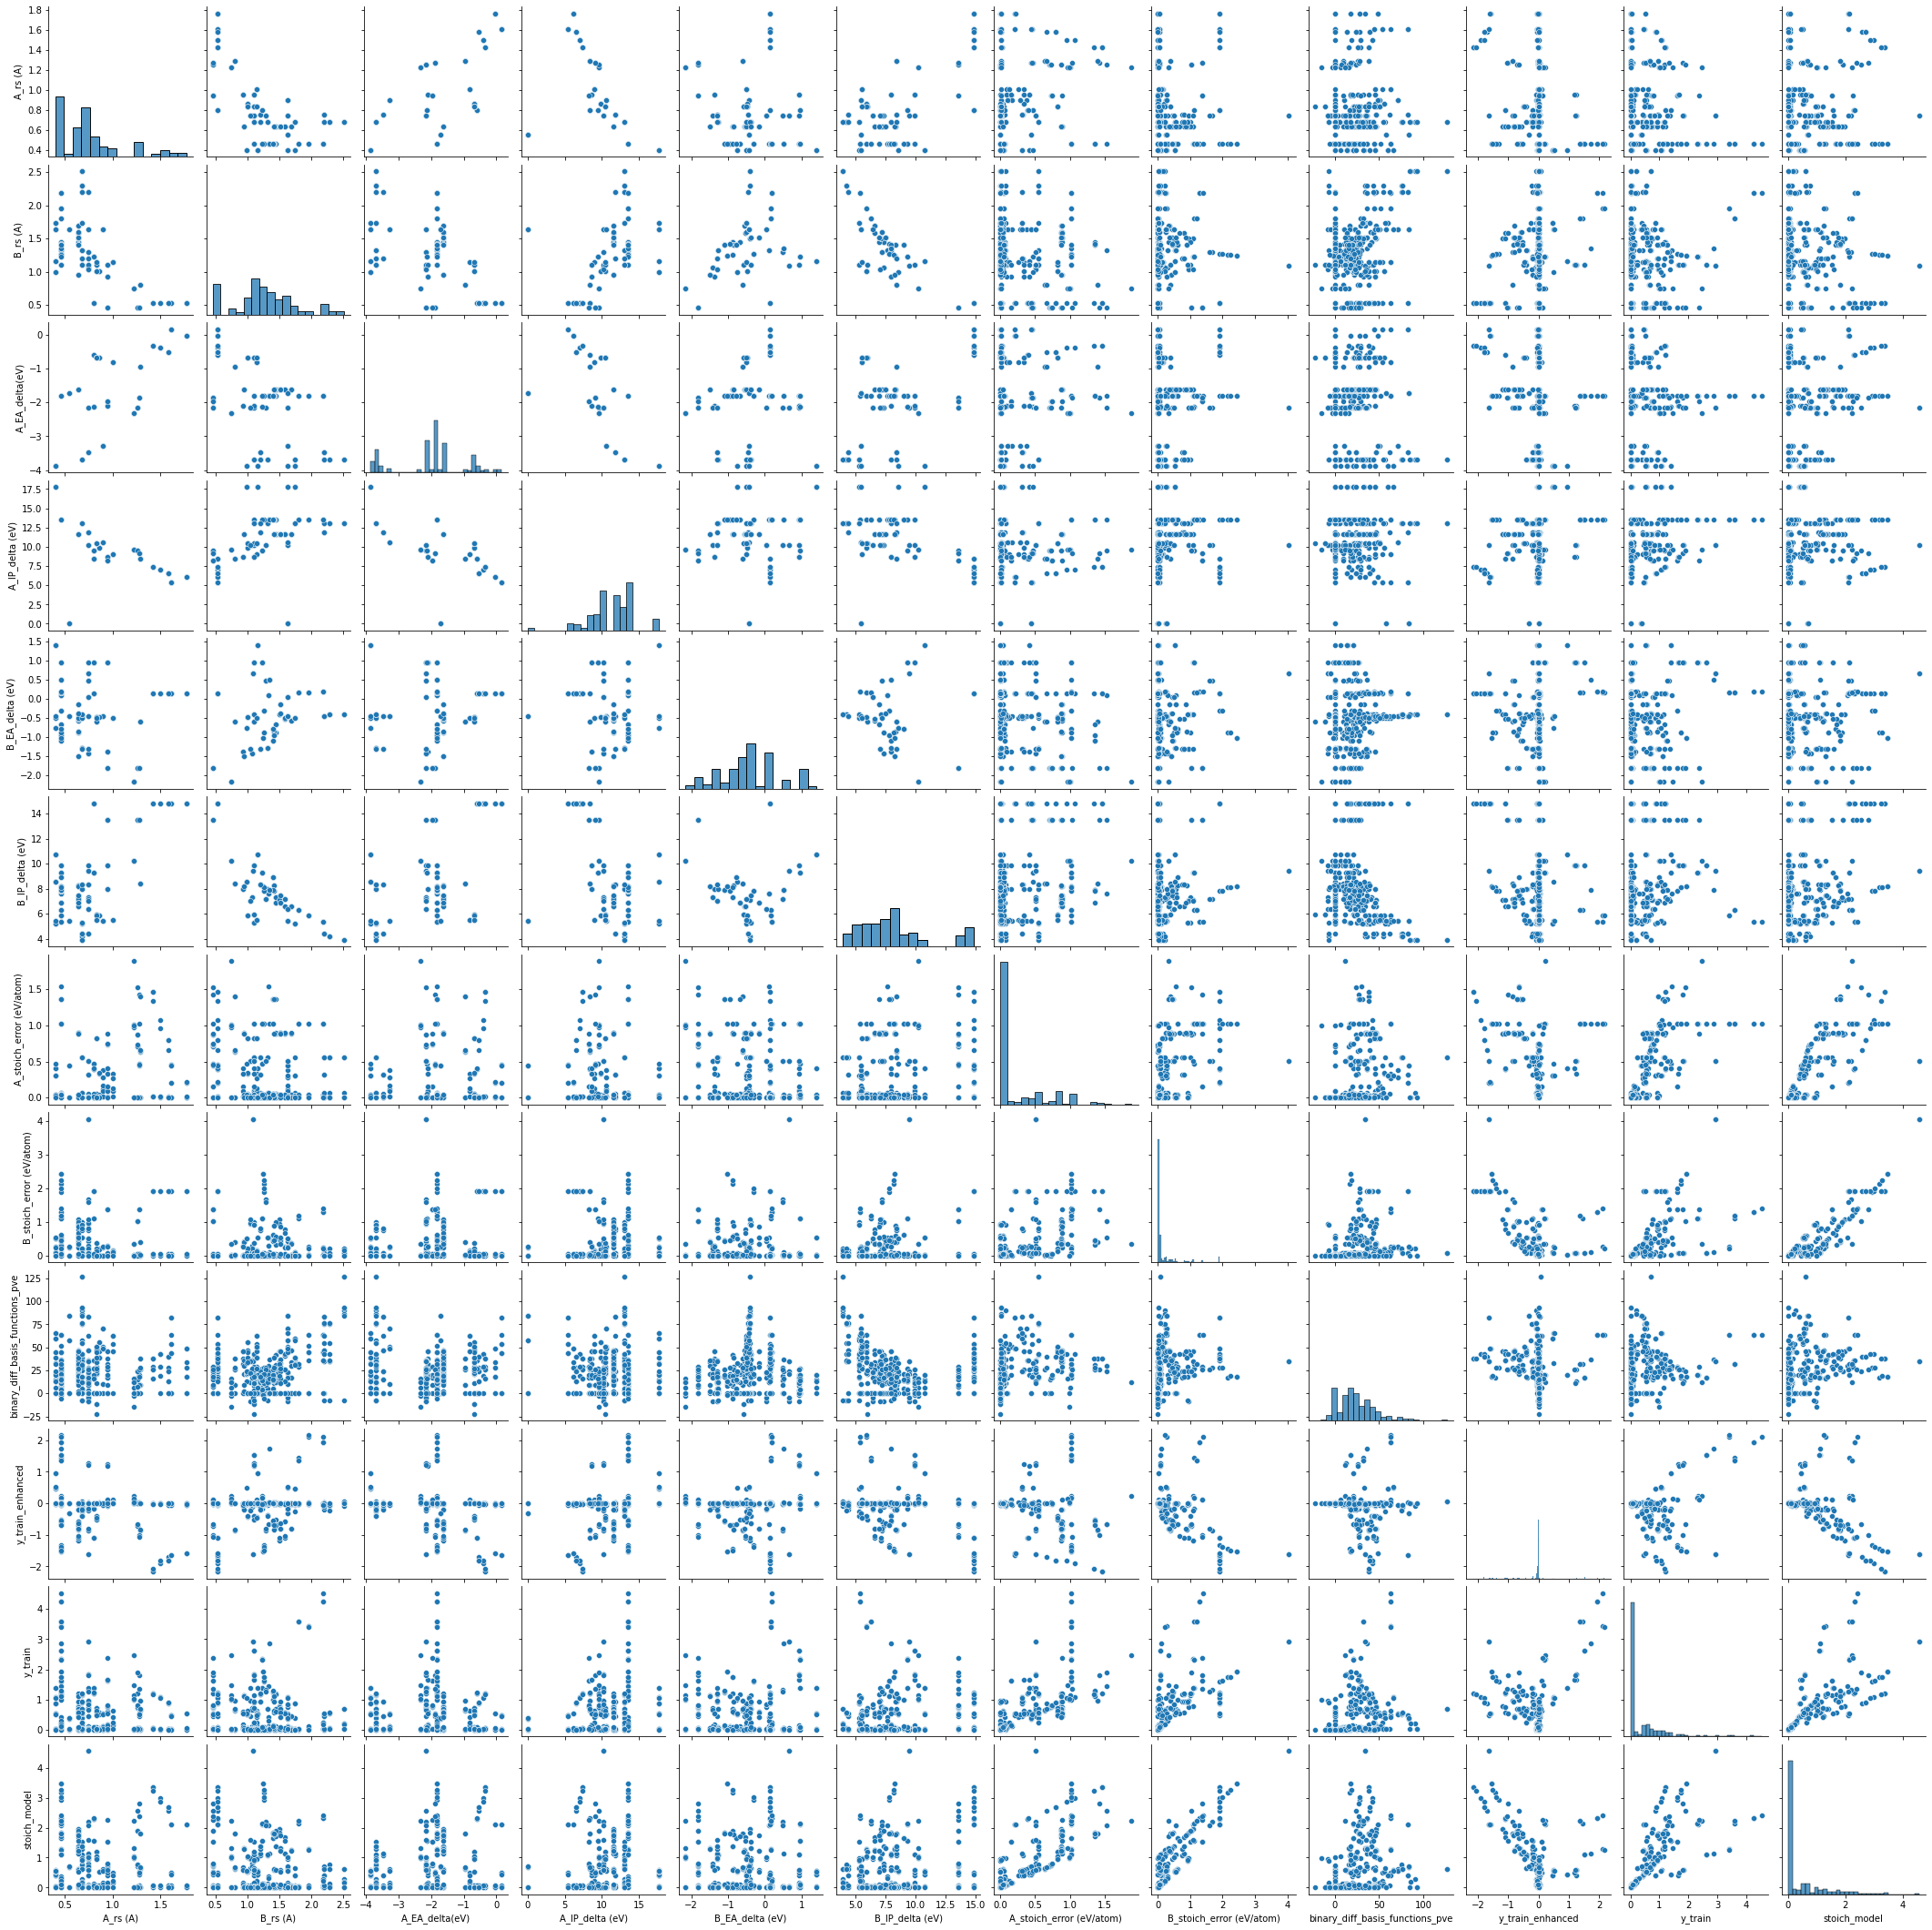

In [4]:
# Plot the correlations of the FHI-aims data. Open this image in a new tab to zoom in on the different features.
sns.pairplot(extended_aims_df)

In [5]:
# We can also then load the exciting data.
exciting_y_test = pd.read_csv(csv_prefix + "exciting_y_test.csv", index_col=0)
exciting_y_train = pd.read_csv(csv_prefix + "exciting_y_train.csv", index_col=0)
exciting_X_train = pd.read_csv(csv_prefix + "exciting_X_train.csv", index_col=0)
exciting_X_test = pd.read_csv(csv_prefix + "exciting_X_test.csv", index_col=0)

exciting_y_test = exciting_y_test["binary_energy_error (eV/atom)"]
exciting_y_train = exciting_y_train["binary_energy_error (eV/atom)"]

# Get the stoichiometric model for train/test data.
exciting_stoich_train = np.add(
    exciting_X_train["A_stoich_error (eV/atom)"].to_numpy(),
    exciting_X_train["B_stoich_error (eV/atom)"].to_numpy(),
)

exciting_y_train_enhanced = exciting_y_train - exciting_stoich_train
exciting_stoich_test = np.add(
    exciting_X_test["A_stoich_error (eV/atom)"].to_numpy(),
    exciting_X_test["B_stoich_error (eV/atom)"].to_numpy(),
)
exciting_y_test_enhanced = exciting_y_test - exciting_stoich_test


min of train residual data - -5.771410053555314
max of train residual data - 22.63220690518847
min of train absolute value of residual data - 7.687223842499803e-06
min of test residual data - -7.362349935411714
max of test residual data - 21.524039143906514
min of test absolute value of residual data - 7.687223842499803e-06
<class 'pandas.core.series.Series'>


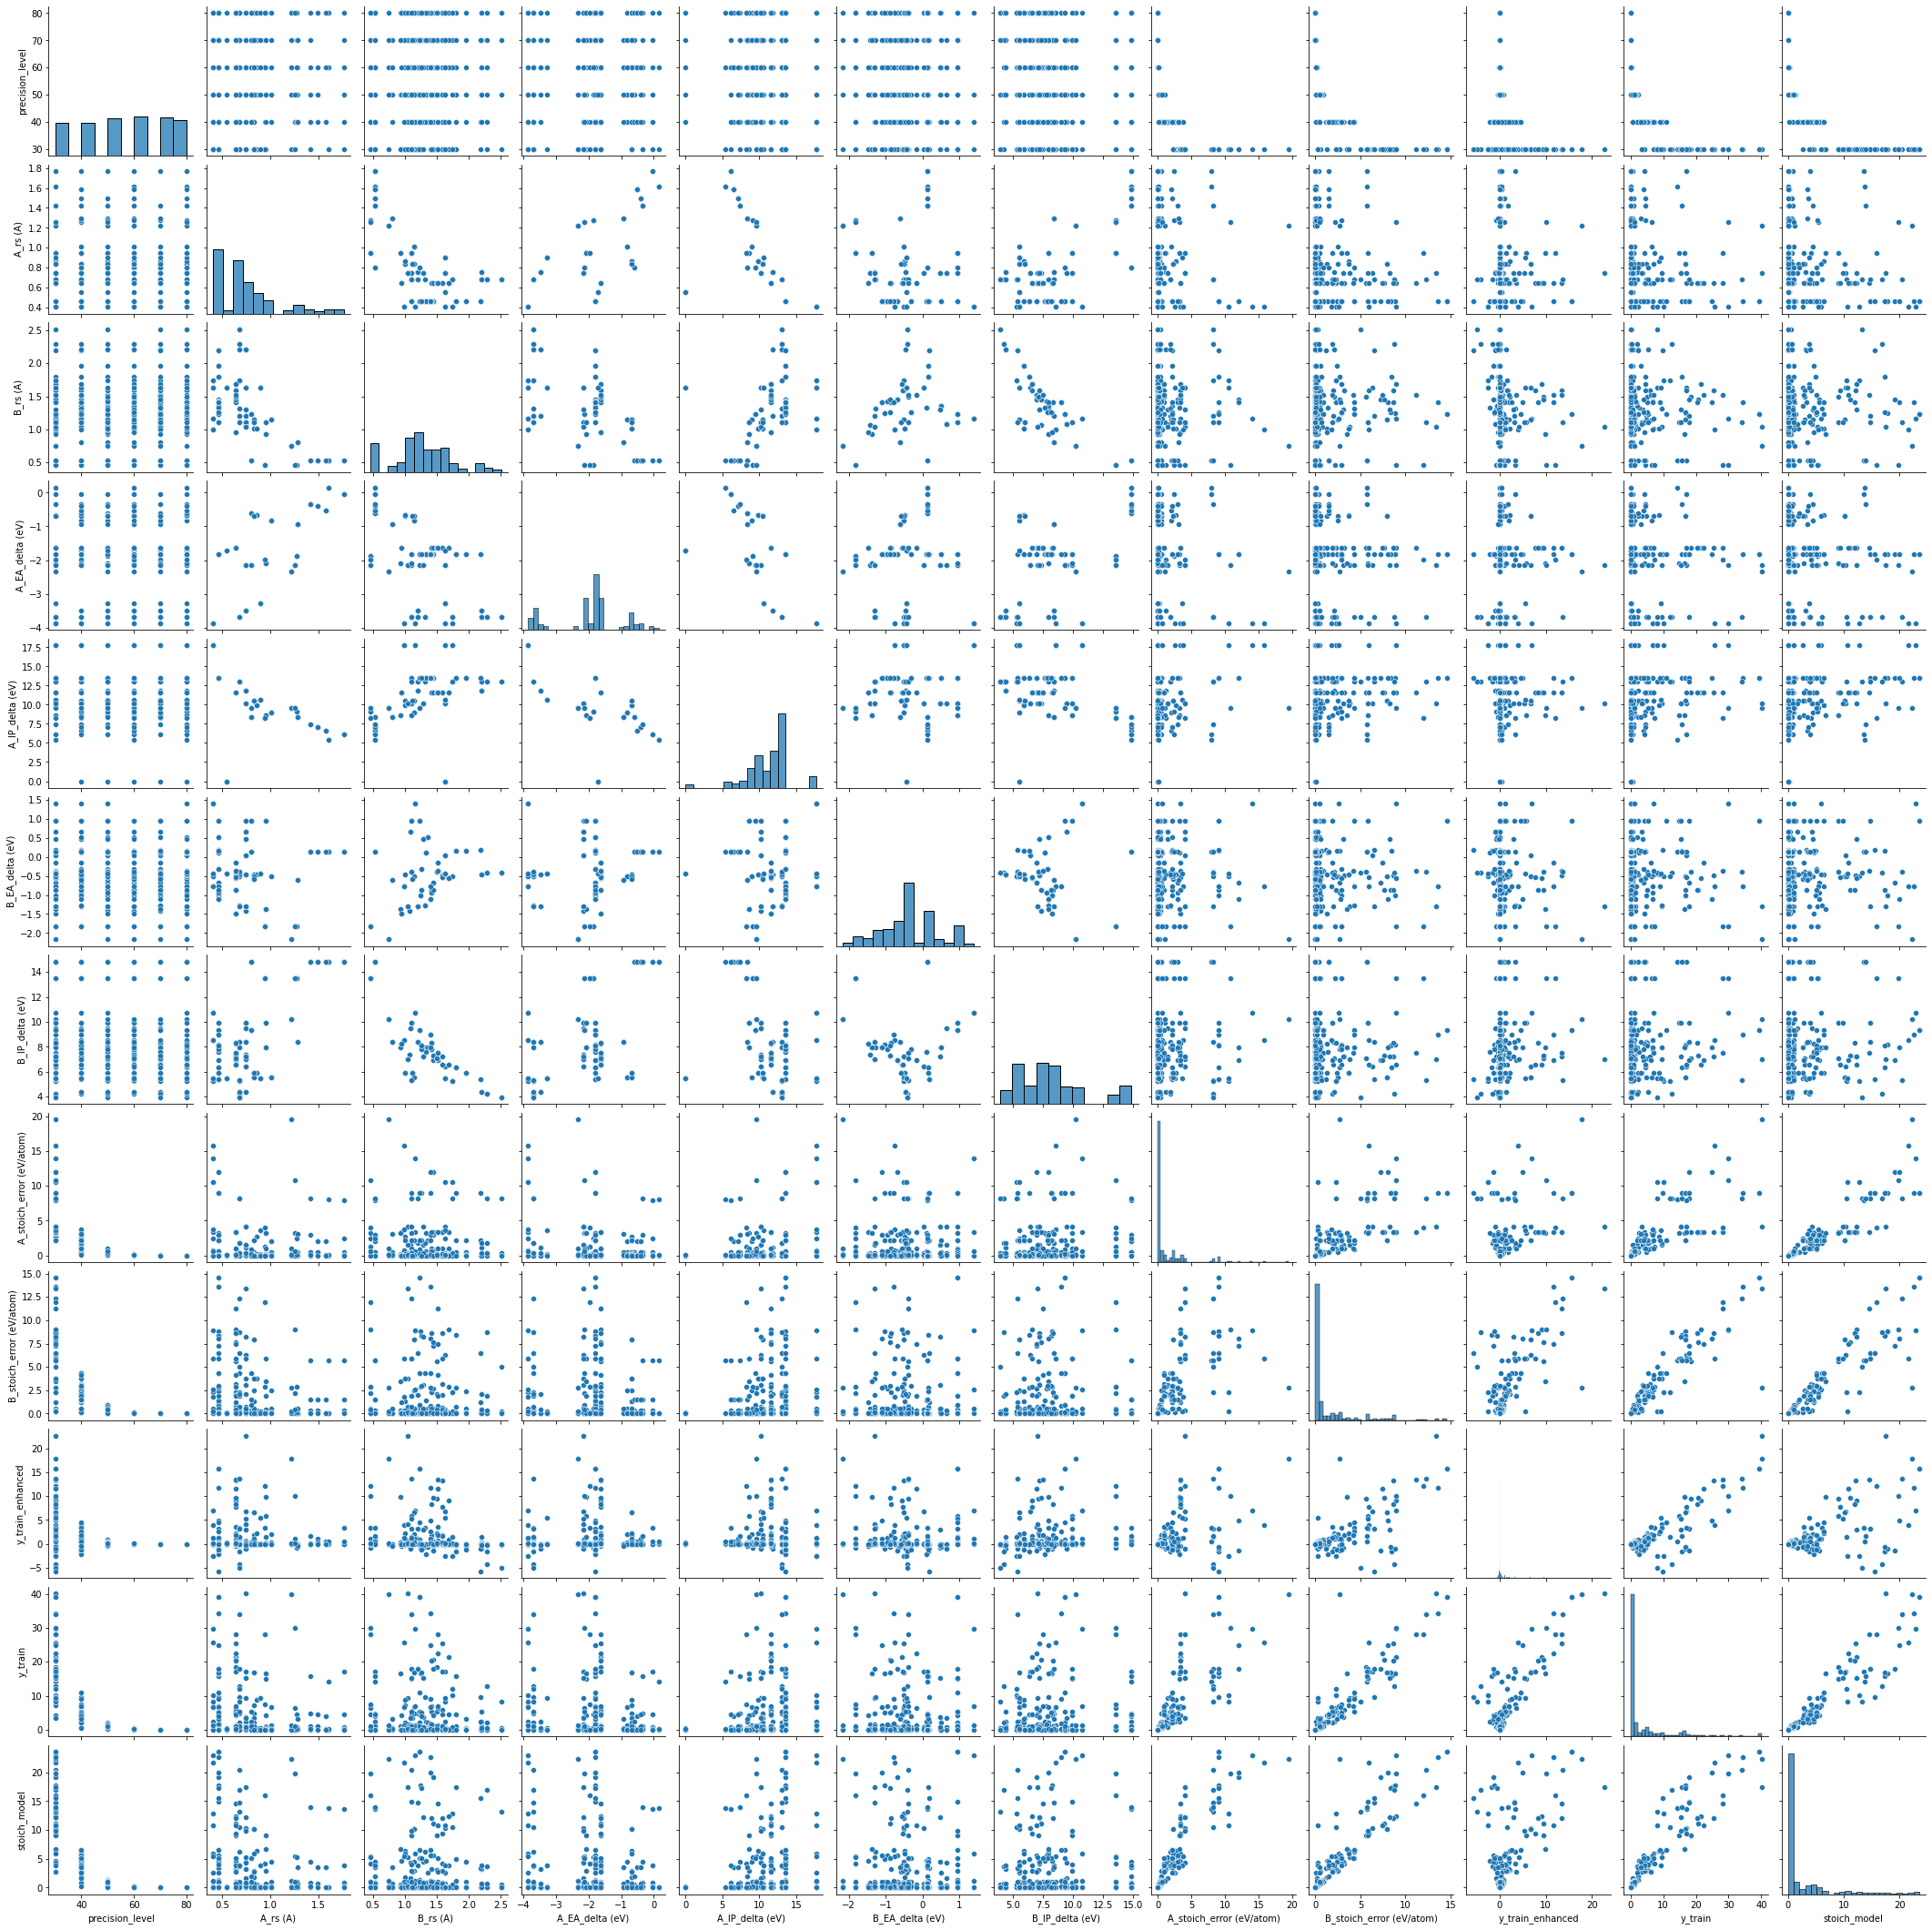

In [6]:
/home/dts/Documents/theory/cbs_error_estimates/tutorial-error-estimates-qrf/cbs_with_qrf.ipynb/home/dts/Documents/theory/cbs_error_estimates/tutorial-error-estimates-qrf/cbs_with_qrf.ipynb/home/dts/Documents/theory/cbs_error_estimates/tutorial-error-estimates-qrf/cbs_with_qrf.ipynb# Print some statistics on the target - stoichiometric data (named exciting_y_train_enhanced)
print(f"min of train residual data - {np.min(exciting_y_train_enhanced)}")
print(f"max of train residual data - {np.max(exciting_y_train_enhanced)}")
print(
    f"min of train absolute value of residual data - {np.min(np.abs(exciting_y_train_enhanced))}"
)

print(f"min of test residual data - {np.min(exciting_y_test_enhanced)}")
print(f"max of test residual data - {np.max(exciting_y_test_enhanced)}")
print(
    f"min of test absolute value of residual data - {np.min(np.abs(exciting_y_test_enhanced))}"
)

print(type(exciting_y_train_enhanced))

# Note we see that the residual data goes from negative values to postive values, meaning we can't use the RMSLE
# error on this data

# Now plot the pariwise correlation plots. Click on the image after it shows up and open in new tab to zoom in on
# specific feature pairs.
extended_exciting_df = exciting_X_train.copy()
extended_exciting_df["y_train_enhanced"] = exciting_y_train_enhanced
extended_exciting_df["y_train"] = exciting_y_train
extended_exciting_df["stoich_model"] = exciting_stoich_train
# Plot the correlations of the data. Open this image in a new tab to zoom in on the different features.
sns.pairplot(extended_exciting_df)

<a id='Metrics_of_Interest'></a>
## Metrics of Interest:

The room mean squared error is defined as:
$$\text{RMSE}= \sqrt{\frac{1}{N}\sum_{i=1}^{N} (h(\bar{x_{i}}) - y_{i})^{2}}$$

where $h(\bar{x_{i}})$ is our prediction and $y_{i}$ is our target. Similarly, optimizing for the RMSE is the same as optimizing for the MSE (defined below) since the square root function is monotonic.

$$\text{MSE} = \sum_{i=1}^{N} (h(\bar{x_{i}}) - y_{i})^{2}$$

The mean absolute error is defined as:

$$\text{MAE} = \sum_{i=1}^{N} |h(\bar{x_{i}}) - y_{i}|$$

The root mean squared logarithmic error is defined as in two manners either as:

$$ \text{RMSLE+1} = \sum \limits _{i=1}^{i=N} (\log(y_{i}+1) - \log(h(\bar{x}_{i})+1))^2 $$

or:

$$ \text{RMSLE+1E-4} = \sum \limits _{i=1}^{i=N} (\log(y_{i}+1E-4) - \log(h(x_{i})+1E-4))^2 $$

We use the RMSLE when are trying to predict the correct order of magnitude. The RMSLE+1E-4 should more accurately reflect a metric that calculates the difference in target in prediction regardless of the order of magnitude of the target compared to the RMSLE considering that our targets range from 1E-6 to 40 eV/atom.

The mean absolute percentage error (MAPE) is defined as:

\begin{equation} \label{eq:mape_opt} \text{MAPE} = \frac{|y_{i} - h(\bar x_{i})|}{|y_{i}|} \end{equation}

While the symmetric mean absolute error is:
\begin{equation}\label{eq:smape} \text{sMAPE} = \frac{|y_{i} - h(\bar x_{i})|}{|y_{i}| + |h(\bar x_{i})|} \end{equation}

In [7]:
# Define metrics we use to compare our models as functions that we can call when evaluating different models.


def mean_absolute_percentage_error(y_true, y_pred):
    """Mean asbolute percentage error metric.

    Args:
        y_true: list of true values/target vals.
        y_pred: list of predictions.

    Returns: mean absolute percentage error.

    Raises:
        ValueError: if the the absolute percentage error is undefined.
    """
    if y_true.any() == 0:  # Then the MAPE is undefined.
        raise ValueError("MAPE not defined for some zero values of y_true")
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def symm_mape(y_true, y_pred):
    """Compute the symmetric mean absolute percentage error.

    Args:
        y_true: list of true values/target vals.
        y_pred: list of predictions.

    Returns: symmetric mean absolute percentage error.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (
        np.mean(np.abs(y_true - y_pred) / (0.5 * np.abs(y_true) + 0.5 * np.abs(y_pred)))
        * 100
    )


def root_mean_squared_log_error(y_true, y_pred):
    """Root Mean Squared Log Error

    Args:
        y_true: list of true values/target vals.
        y_pred: list of predictions.

    Returns: Root mean squared log error defined as:
        sqrt(1/n Sum(over i=1 to N) (log(y(i)+1) - log(h(i)+1)^2)
        The +1 for the true value and the log value ensures that
        we small negative true targets or predictions won't cause
        this function to be undefined.

    Raises:
        ValueError: if the log(y(i)) or log(h(i)) are undefined
    """
    try:
        rmsle = np.sqrt(
            1 / len(y_true) * np.sum(np.square(np.log(y_true) - np.log(y_pred)))
        )
        return rmsle
    except ValueError:
        raise ValueError


def root_mean_squared_log_error_plus1emin4(y_true, y_pred):
    """Root Mean Squared Log Error

    Args:
        y_true: list of true values/target vals.
        y_pred: list of predictions.

    Returns: Root mean squared log error defined as:
        sqrt(1/n Sum(over i=1 to N) (log(y(i)+1) - log(h(i)+1)^2)
        The +1 for the true value and the log value ensures that
        we small negative true targets or predictions won't cause
        this function to be undefined.

    Raises:
        ValueError: if the log(y(i) + 1) or log(h(i) + 1) are undefined
        since either the y(i) < -1 or h(i) <-1."""
    try:
        rmsle = np.sqrt(
            1
            / len(y_true)
            * np.sum(np.square(np.log(y_true + 1e-4) - np.log(y_pred + 1e-4)))
        )
        return rmsle
    except ValueError:
        raise ValueError


def root_mean_squared_log_error_plus_one(y_true, y_pred):
    """Root Mean Squared Log Error

    Args:
    y_true (np.array): list of true values/target vals
    y_pred (np.array): list of predictions

    Returns:
    rmsle: Root mean squared log error defined as:
        sqrt(1/n Sum(over i=1 to N) (log(y(i)+1) - log(h(i)+1)^2)
        The +1 for the true value and the log value ensures that
        we small negative true targets or predictions won't cause
        this function to be undefined.

    Raises:
    ValueError: if the log(y(i) + 1) or log(h(i) + 1) are undefined
        since either the y(i) < -1 or h(i) <-1."""
    try:
        rmsle = np.sqrt(
            1 / len(y_true) * np.sum(np.square(np.log(y_true + 1) - np.log(y_pred + 1)))
        )
        return rmsle
    except ValueError:
        raise ValueError


def neg_root_mean_squared_log_error_plus_one(y_true, y_pred):
    """Root Mean Squared Log Error but used for optimization.

    We don't use this funciton in the below cells but we experimented using it. Feel free
    to try it out below.

    Args:
    y_true (np.array): list of true values/target vals
    y_pred (np.suggestions of refereesarray): list of predictions

    Returns:
    rmsle: Root mean squared log error defined as:
        sqrt(1/n Sum(over i=1 to N) (log(y(i)+1) - log(h(i)+1)^2)
        The +1 for the true value and the log value ensures that
        we small negative true targets or predictions won't cause
        this function to be undefined.

    Raises:
    ValueError: if the log(y(i) + 1) or log(h(i) + 1) are undefined
        since either the y(i) < -1 or h(i) <-1."""
    try:
        rmsle = -np.sqrt(
            1 / len(y_true) * np.sum(np.square(np.log(y_true + 1) - np.log(y_pred + 1)))
        )
        return rmsle
    except ValueError:
        raise ValueError


def ninety_five_percent_quantile(y_true, y_pred):
    return np.quantile(np.abs(y_true - y_pred), quantile)


def get_metrics_report(y_true, y_pred, rmsle_plus_1e4=False):
    """Get list of metrics for the model predictions."""
    print(f"RMSLE+1 is {root_mean_squared_log_error_plus_one(y_true, y_pred)}")
    print(f"MAPE is {mean_absolute_percentage_error(y_true, y_pred)}")
    print(f"sMAPE is {symm_mape(y_true, y_pred)}")
    print(f"MAE is {mean_absolute_error(y_true, y_pred)}")
    print(f"StDev in the target {np.std(y_true)}")
    print(f"95% quantile absolute error is: {np.quantile(np.abs(y_true-y_pred), 0.95)}")
    if rmsle_plus_1e4:
        print(f"RMSLE+1E-4 is {root_mean_squared_log_error_plus1emin4(y_true, y_pred)}")

# AIMS QRF

We first train an random forest on the energy corrections. Note, we call this model the Qunatile Random Forest model but the quantiles are only used in a later cell when we evaluate the uncertainty. There are two ways use to a quantile random forest for predictions. One way is to predict the median of the quantiles the over way is to predict the mean of the quantiles. If you use the mean you minimize the MSE. We are using the RMLSE as our target metric and therefore don't have a strong preference for the mean or the median. We, however, opt to use the mean for simplicity's sake. This means our QRF acts like a RF when it makes inferences and the quantile part of the QRF is used when we add uncertainty estimates in the form of prediction intervals to our predictions.

Note we have to make a custom scorer in the API since sk-learn forces us when we want to fit our root mean squared log error with a small epsilon value. We use this target metric since we don't want to only fit the large energy corrections since our data spans several orders of magnitude.

In [8]:
# We then can train a Run AIMS Random Forest using sci-kit learn's python library.

param_grid = {
    "bootstrap": [True],
    "max_features": [0.1, 0.3, 0.6, 0.9, 1],
    "min_samples_leaf": [1, 3, 5],
    "n_estimators": [50, 75, 100, 125, 150, 200, 250, 300],
}


aims_rando_for_gs = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
    refit=True,
    scoring=make_scorer(
        root_mean_squared_log_error_plus1emin4, greater_is_better=False
    ),
)

aims_rando_for_gs.fit(aims_X_train, aims_y_train)

print("The Best Params Are:")
print(aims_rando_for_gs.best_params_)

print("\n Train Metrics:")
get_metrics_report(
    aims_y_train, aims_rando_for_gs.predict(aims_X_train), rmsle_plus_1e4=True
)
print("\n Test Metrics:")
get_metrics_report(
    aims_y_test, aims_rando_for_gs.predict(aims_X_test), rmsle_plus_1e4=True
)

The Best Params Are:
{'bootstrap': True, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators': 150}

 Train Metrics:
RMSLE+1 is 0.015092734113125103
MAPE is 28.972203985608918
sMAPE is 10.642344806280542
MAE is 0.013376825681623919
StDev in the target 0.6922287677892799
95% quantile absolute error is: 0.07172223843503978
RMSLE+1E-4 is 0.21395026475076703

 Test Metrics:
RMSLE+1 is 0.040443635398514734
MAPE is 15.323186274820957
sMAPE is 13.945401525191425
MAE is 0.03772914791195036
StDev in the target 0.7382825543998104
95% quantile absolute error is: 0.21161517203072383
RMSLE+1E-4 is 0.2186349852538379


# Aims Combined (Stoich + QRF) Model

What if we train the RF model on the residuals of the stoichiometric model? We try this idea out here. The QRF model is fit to the CBS energy corrections once they've had the stoichiometric model predictions subtracted from them. We then evaluate the model by summing the QRF fit on the residuals with the stoichiometric model.

Note, for this model we use the symmetric mean absolute percentage error (sMAPE) metric since the residual is not gauranteed to be positive. This means that we could easily run into issues if we try to use the RMSLE metric since the RMSLE takes the log of the target plus some small epsilon. For these residuals the epsilon

In [9]:
# Run AIMS Random Forest that targets stoichiometric model residuals.
param_grid = {
    "bootstrap": [True],
    "max_features": [0.1, 0.3, 0.6, 0.9, 1],
    "min_samples_leaf": [1, 3, 5],
    "n_estimators": [75, 100, 125, 150, 200, 250, 300],
}


aims_rando_for_gs_combined = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
    refit=True,
    scoring=make_scorer(symm_mape, greater_is_better=False),
)
# Note we now fit our model not on aims_y_train but on aims_y_train_enhanced.
# aims_y_train_enhanced is aims_y_train - stoichiometric model predictions.
aims_rando_for_gs_combined.fit(aims_X_train, aims_y_train_enhanced)

print("The Best Params Are:")
print(aims_rando_for_gs_combined.best_params_)

# Note for comparison's sake however, we want see how this strategy works with respect to the
# original targets which are aims_y_train. Therefore we combine our QRF fit to the residuals with
# our stoichiometric model via a sum and compare this result to the aims_y_train data.
print("\n Train Metrics")
get_metrics_report(
    aims_y_train,
    aims_rando_for_gs_combined.predict(aims_X_train) + np.array(aims_stoich_train),
)
print("\n Test Metrics")
get_metrics_report(
    aims_y_test,
    aims_rando_for_gs_combined.predict(aims_X_test) + np.array(aims_stoich_test),
)

The Best Params Are:
{'bootstrap': True, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators': 200}

 Train Metrics
RMSLE+1 is 0.014010338354705186
MAPE is 33.576819302249916
sMAPE is 10.806637769727503
MAE is 0.01393879689560296
StDev in the target 0.6922287677892799
95% quantile absolute error is: 0.07377652000009191

 Test Metrics
RMSLE+1 is 0.031666895683740856
MAPE is 24.45877234041882
sMAPE is 15.770948932327197
MAE is 0.031873669115920274
StDev in the target 0.7382825543998104
95% quantile absolute error is: 0.16206534270123524


# **exciting** QRF Model

We now want to follow the same proceedure we just did for FHI-aims but now using **exciting** DFT data. We again perform a 10 fold cross validation with a grid of parameters. We take the best performing parameters using this cross-validation strategy. We show results on the training and test datasets.

In [10]:
# Train the QRF model on the exciting data.
# Set up the parameter grid, we try all of these values for our QRF model
# and choose the one that does best with 10 fold cross-validation.
param_grid = {
    "bootstrap": [True],
    "max_features": [0.1, 0.3, 0.6, 0.9, 1],
    "min_samples_leaf": [1, 3, 5],
    "n_estimators": [50, 75, 100, 125, 150, 200, 250, 300],
}

# Create a grid search object and feed in our parameter grid.
exciting_rando_for_gs = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
    refit=True,
    scoring=make_scorer(
        root_mean_squared_log_error_plus1emin4, greater_is_better=False
    ),
)

# Fit our model. This should output the best peforming model on the CV folds.
exciting_rando_for_gs.fit(exciting_X_train, exciting_y_train)

print("The Best Params Are:")
print(exciting_rando_for_gs.best_params_)

print("\n Train Metrics")
get_metrics_report(
    exciting_y_train,
    exciting_rando_for_gs.predict(exciting_X_train),
    rmsle_plus_1e4=True,
)
print("\n Test Metrics")
get_metrics_report(
    exciting_y_test, exciting_rando_for_gs.predict(exciting_X_test), rmsle_plus_1e4=True
)

The Best Params Are:
{'bootstrap': True, 'max_features': 0.9, 'min_samples_leaf': 1, 'n_estimators': 50}

 Train Metrics
RMSLE+1 is 0.06892054935800106
MAPE is 11.615692177348457
sMAPE is 10.573797369455292
MAE is 0.3133462177892852
StDev in the target 7.694978028758609
95% quantile absolute error is: 1.5840849961935586
RMSLE+1E-4 is 0.15051059765208824

 Test Metrics
RMSLE+1 is 0.20187240645163754
MAPE is 27.34384814406347
sMAPE is 24.190132281626024
MAE is 1.4368401470574392
StDev in the target 8.127725119395418
95% quantile absolute error is: 7.794794873997005
RMSLE+1E-4 is 0.3175970344198013


# Exciting Combined (stoichiometric + QRF) Model

Same story here. We fit a new RF model to the residuals of the stoichiometric model for exciting data. We then combine the two models when performing the evaluation.

In [11]:
# Run exciting Random Forest.
# Now let's build a random forest model

param_grid = {
    "bootstrap": [True],
    "max_features": [0.3, 0.6, 0.9, 1],
    "min_samples_leaf": [1, 3, 5],
    "n_estimators": [50, 75, 100, 125, 150, 200, 250, 300],
}


exciting_rando_for_gs_combined = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
    refit=True,
    scoring=make_scorer(symm_mape, greater_is_better=False),
)

exciting_rando_for_gs_combined.fit(exciting_X_train, exciting_y_train_enhanced)

print("The Best Params Are:")
print(exciting_rando_for_gs_combined.best_params_)

print("\n Train Metrics:")
get_metrics_report(
    exciting_y_train,
    exciting_rando_for_gs_combined.predict(exciting_X_train)
    + np.array(exciting_stoich_train),
)
print("\n Test Metrics:")
get_metrics_report(
    exciting_y_test,
    exciting_rando_for_gs_combined.predict(exciting_X_test)
    + np.array(exciting_stoich_test),
)

The Best Params Are:
{'bootstrap': True, 'max_features': 0.6, 'min_samples_leaf': 1, 'n_estimators': 200}

 Train Metrics:
RMSLE+1 is 0.061384651256823665
MAPE is 27.771731328739218
sMAPE is 13.347752454468464
MAE is 0.2605893180984592
StDev in the target 7.694978028758609
95% quantile absolute error is: 1.3406534757063264

 Test Metrics:
RMSLE+1 is 0.18747639644414524
MAPE is 27.193098390670116
sMAPE is 26.380334962177905
MAE is 1.360533157308964
StDev in the target 8.127725119395418
95% quantile absolute error is: 8.47245889907653


## Summary of Model Results on Test Data for Comparison

We print out the test data results for all models side by side in a single cell for comparison's sake. We do this for the test data in this cell and for the training data in the following cell.

In [12]:
# Combine the model predictions and results into a single dataframe for the test data
# for the FHI-aims data.
aims_result_df = pd.DataFrame({})
aims_result_df["aims_qrf_prediction"] = aims_rando_for_gs.predict(aims_X_test)
aims_result_df["aims_combined_prediction"] = aims_rando_for_gs_combined.predict(
    aims_X_test
) + np.array(aims_stoich_test)

aims_result_df["aims_y_true"] = aims_y_test.to_numpy()
aims_result_df["aims_stoichiometric"] = aims_stoich_test

# Similarly, we combine the model predictions on the test data and the test data targets into
# a single dataframe for the exciting data.
exciting_result_df = pd.DataFrame({})
exciting_result_df["exciting_qrf_prediction"] = exciting_rando_for_gs.predict(
    exciting_X_test
)
exciting_result_df[
    "exciting_combined_prediction"
] = exciting_rando_for_gs_combined.predict(exciting_X_test) + np.array(
    exciting_stoich_test
)
exciting_result_df["exciting_y_true"] = exciting_y_test.to_numpy()

exciting_result_df["exciting_stoichiometric"] = exciting_stoich_test


print("aims qrf results:")
get_metrics_report(
    aims_result_df["aims_y_true"],
    aims_result_df["aims_qrf_prediction"],
    rmsle_plus_1e4=True,
)

print("\n")
print("aims QRF + stoichiometric results:")
get_metrics_report(
    aims_result_df["aims_y_true"], aims_result_df["aims_combined_prediction"]
)

print("\n")
print("aims stoichiometric results:")
get_metrics_report(
    aims_result_df["aims_y_true"],
    aims_result_df["aims_stoichiometric"],
    rmsle_plus_1e4=True,
)


print("\n")
print("exciting QRF results:")
get_metrics_report(
    exciting_result_df["exciting_y_true"],
    exciting_result_df["exciting_qrf_prediction"],
    rmsle_plus_1e4=True,
)

print("\n")
print("exciting QRF+stoichiometric results:")
get_metrics_report(
    exciting_result_df["exciting_y_true"],
    exciting_result_df["exciting_combined_prediction"],
)

print("\n")
print("exciting stoichiometric results:")
get_metrics_report(
    exciting_result_df["exciting_y_true"],
    exciting_result_df["exciting_stoichiometric"],
    rmsle_plus_1e4=True,
)

aims qrf results:
RMSLE+1 is 0.040443635398514734
MAPE is 15.323186274820957
sMAPE is 13.945401525191425
MAE is 0.03772914791195036
StDev in the target 0.7382825543998104
95% quantile absolute error is: 0.21161517203072383
RMSLE+1E-4 is 0.2186349852538379


aims QRF + stoichiometric results:
RMSLE+1 is 0.031666895683740856
MAPE is 24.45877234041882
sMAPE is 15.770948932327197
MAE is 0.031873669115920274
StDev in the target 0.7382825543998104
95% quantile absolute error is: 0.16206534270123524


aims stoichiometric results:
RMSLE+1 is 0.20321010146887408
MAPE is 58.155225296887004
sMAPE is 48.87811514821301
MAE is 0.25645635190139987
StDev in the target 0.7382825543998104
95% quantile absolute error is: 1.5196033608267037
RMSLE+1E-4 is 0.6634827642274194


exciting QRF results:
RMSLE+1 is 0.20187240645163754
MAPE is 27.34384814406347
sMAPE is 24.190132281626024
MAE is 1.4368401470574392
StDev in the target 8.127725119395418
95% quantile absolute error is: 7.794794873997005
RMSLE+1E-4 is

In [13]:
# Get the Training Error of the different models:

# Collect FHI-aims results on training data.
aims_result_df_train = pd.DataFrame({})
aims_result_df_train["aims_qrf_prediction_training"] = aims_rando_for_gs.predict(
    aims_X_train
)
aims_result_df_train["aims_combined_prediction_training"] = (
    aims_rando_for_gs_combined.predict(aims_X_train) + aims_stoich_train
)
aims_result_df_train["aims_stoichiometric_training"] = aims_stoich_train
aims_result_df_train["aims_y_true_training"] = aims_y_train.to_numpy()


# Collect exciting results on training data.
exciting_result_df_train = pd.DataFrame({})
exciting_result_df_train[
    "exciting_qrf_prediction_training"
] = exciting_rando_for_gs.predict(exciting_X_train)
exciting_result_df_train["exciting_combined_prediction_training"] = (
    exciting_rando_for_gs_combined.predict(exciting_X_train) + exciting_stoich_train
)
exciting_result_df_train["exciting_y_true_training"] = exciting_y_train.to_numpy()
exciting_result_df_train["exciting_stoichiometric_training"] = exciting_stoich_train

print("FHI-aims QRF training results:")
get_metrics_report(
    aims_result_df_train["aims_y_true_training"],
    aims_result_df_train["aims_qrf_prediction_training"],
    rmsle_plus_1e4=True,
)

print("\n\n")
print("FHI-aims combined QRF+stoichiometric training results:")
get_metrics_report(
    aims_result_df_train["aims_y_true_training"],
    aims_result_df_train["aims_combined_prediction_training"],
)

print("\n")
print("FHI-aims stoichiometric training results:")
get_metrics_report(
    aims_result_df_train["aims_y_true_training"],
    aims_result_df_train["aims_stoichiometric_training"],
    rmsle_plus_1e4=True,
)

print("\n")
print("exciting QRF training results:")
get_metrics_report(
    exciting_result_df_train["exciting_y_true_training"],
    exciting_result_df_train["exciting_qrf_prediction_training"],
    rmsle_plus_1e4=True,
)

print("\n")
print("exciting combined QRF+stoichiometric training results:")
get_metrics_report(
    exciting_result_df_train["exciting_y_true_training"],
    exciting_result_df_train["exciting_combined_prediction_training"],
)

print("\n")
print("exciting stoichiometric training results:")
get_metrics_report(
    exciting_result_df_train["exciting_y_true_training"],
    exciting_result_df_train["exciting_stoichiometric_training"],
    rmsle_plus_1e4=True,
)

FHI-aims QRF training results:
RMSLE+1 is 0.015092734113125103
MAPE is 28.972203985608918
sMAPE is 10.642344806280542
MAE is 0.013376825681623919
StDev in the target 0.6922287677892799
95% quantile absolute error is: 0.07172223843503978
RMSLE+1E-4 is 0.21395026475076703



FHI-aims combined QRF+stoichiometric training results:
RMSLE+1 is 0.014010338354705186
MAPE is 33.576819302249916
sMAPE is 10.806637769727503
MAE is 0.01393879689560296
StDev in the target 0.6922287677892799
95% quantile absolute error is: 0.07377652000009191


FHI-aims stoichiometric training results:
RMSLE+1 is 0.18865091034866
MAPE is 70.06387496661837
sMAPE is 53.266301459308174
MAE is 0.21222025719823562
StDev in the target 0.6922287677892799
95% quantile absolute error is: 1.4203935264050835
RMSLE+1E-4 is 0.9166400535719966


exciting QRF training results:
RMSLE+1 is 0.06892054935800106
MAPE is 11.615692177348457
sMAPE is 10.573797369455292
MAE is 0.3133462177892852
StDev in the target 7.694978028758609
95% qua

## SISSO Models

In [14]:
# FHI-aims Model
aims_sisso_trained_model_output_path = 'data/error_estimates_qrf/sisso_aims_trained_model_predictions.csv'

# This is the output from SISSO showing how the model looks like:
# c0 + a0 * ((cbrt(B_stoich_error-3.650094e-03)) * ((A_rs-8.325144e-01)^3))
# + a1 * ((B_EA_delta / B_rs) / (sqrt(1.0*A_stoich_error+1.542960e-03)))
# a2 * (ln(1.0*(B_stoich_error + 7.783566e-01*A_stoich_error)+5.518911e-04))


aims_sisso_model_ln_reparam_df = pd.read_csv(aims_sisso_trained_model_output_path)
aims_sisso_prediction = np.exp(
    aims_sisso_model_ln_reparam_df['  Property Value (EST) ']).to_numpy()
aims_result_df['indices'] = [497, 231, 212, 118, 670, 539, 260, 210, 145, 582, 338, 601, 408, 618, 647, 529, 90, 54, 619, 182, 302, 651, 277, 292, 584, 244, 675, 155, 135, 432, 639, 452, 321, 63, 77, 632, 411, 375, 109, 72, 132, 213, 606, 10, 264, 328, 640, 480, 665, 31, 78, 349, 361, 265, 671, 327, 55, 547, 367, 120, 136, 672, 2, 218, 679, 381, 319, 101, 493, 81, 634, 290, 76, 453, 535, 60, 656, 30, 69, 395, 603, 44, 70, 165, 289, 354, 133, 521, 299, 551, 342, 65, 380, 49, 329, 131, 39, 486, 220, 6, 148, 350, 192, 164, 590, 594, 199, 680, 515, 86, 501, 291, 559, 635, 405, 530, 41, 204, 108, 234, 56, 215, 468, 294, 318, 235, 500, 534, 24, 158, 645, 278, 110, 82, 51, 211, 549]
# only run this cell once or else it will sort again:
aims_result_df = aims_result_df.sort_values(by=['indices'])

aims_result_df['aims_sisso_prediction'] = aims_sisso_prediction
aims_sisso_prediction[0:10]
aims_result_df['aims_y_true']

get_metrics_report(aims_result_df['aims_y_true'],
                   aims_result_df['aims_sisso_prediction'],
                   rmsle_plus_1e4=True)

RMSLE+1 is 0.20189031034474342
MAPE is 45.35157417225055
sMAPE is 39.93252903771108
MAE is 0.2065820848952477
StDev in the target 0.7382825543998104
95% quantile absolute error is: 1.1414326558955243
RMSLE+1E-4 is 0.5804589927163292


In [15]:
# exciting SISSO Model
exciting_sisso_trained_model_output_path = 'data/error_estimates_qrf/sisso_exciting_trained_model_predictions.csv'

# path = '/home/dts/Documents/theory/errorbar_modelling/sci_data_paper_data/sissopp/exciting_less_features_ln_correct_indices_reparam.csv'

# c0 + a0 * ((exp(-1.0 * (6.179185e-01*B_IP_delta))) / ((A_EA_delta+1.904487e+00)^3))
# a1 * ((exp(-1.0 * (2.082592e+00*B_IP_delta))) / (B_EA_delta + A_IP_delta))
# a2 * (ln(1.0*(B_stoich_error + 4.714003e-01*A_stoich_error)+8.124290e-05))



exciting_sisso_model_ln_reparam_df = pd.read_csv(exciting_sisso_trained_model_output_path)
exciting_sisso_prediction = np.exp(
    exciting_sisso_model_ln_reparam_df['  Property Value (EST) ']).to_numpy()
exciting_result_df['indices'] = [9, 42, 33, 311, 272, 377, 55, 268, 245, 113, 265, 153, 76, 202, 278, 271, 93, 15, 124, 231, 0, 194, 367, 181, 78, 131, 126, 253, 244, 379, 378, 46, 223, 72, 281, 77, 347, 25, 108, 165, 140, 320, 90, 351, 301, 39, 56, 370, 148, 118, 116, 368, 57, 22, 31, 82, 155, 318, 73, 30, 180, 327, 326, 255, 172, 137, 5, 45, 114, 237, 369, 375, 110, 381, 3, 18, 94, 338]
# only run this cell once or else it will sort again:
exciting_result_df = exciting_result_df.sort_values(by=['indices'])
exciting_result_df['exciting_sisso_prediction'] = exciting_sisso_prediction
get_metrics_report(exciting_result_df['exciting_y_true'],
                   exciting_result_df['exciting_sisso_prediction'],
                   rmsle_plus_1e4=True)

RMSLE+1 is 0.17880215467725383
MAPE is 23.55936748765552
sMAPE is 23.56834700490453
MAE is 1.2958128209628998
StDev in the target 8.127725119395416
95% quantile absolute error is: 6.004047409528635
RMSLE+1E-4 is 0.3072650396276316


In [16]:
exciting_result_df['exciting_y_true']

20     1.614607
74     8.501376
66    15.550663
0      7.558066
17    21.354033
        ...    
71     0.001380
5      0.002198
30     0.002075
29     0.001951
73     0.000969
Name: exciting_y_true, Length: 78, dtype: float64

## Plot True vs. Predicted for Best Models

Plot in the next cell the regression plots, meaning the true CBS energy errors and the predictions from our model. If the model works well the datapoints should all lie on a 45 degree line from the origin.

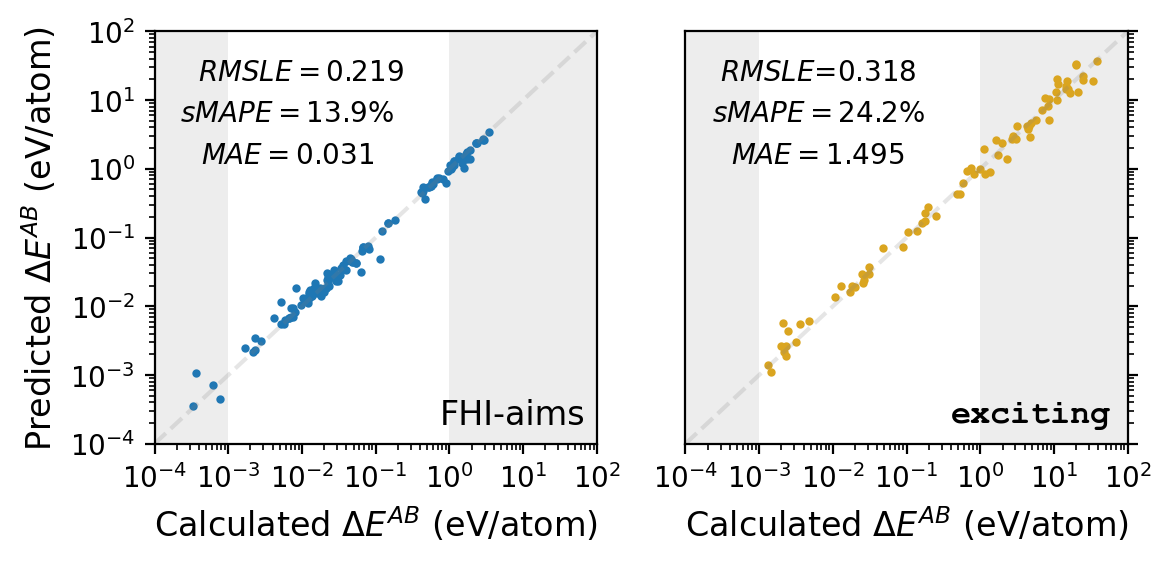

In [17]:
# Set some matplotlib settings.
%config InlineBackend.figure_format='retina'
%matplotlib inline
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
marker_size = 4
fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={"height_ratios": [1]})

# Now create the regression plot for the FHI-aims QRF predictions against the FHI-aims data.
ax[0].plot(
    aims_result_df["aims_y_true"],
    aims_result_df["aims_qrf_prediction"],
    ".",
    markersize=marker_size,
    alpha=1,
)

ax[0].set_xscale("log")
ax[0].set_yscale("log")

ax[0].set_xlim(1e-4, 100)
ax[0].set_ylim(1e-4, 100)
ax[0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[0].set_ylabel("Predicted $\Delta E^{AB}$ (eV/atom)", fontsize=12)
ax[0].set_xlabel("Calculated $\Delta E^{AB}$ (eV/atom)", fontsize=12)

ax[0].minorticks_on()
ax[0].yaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=9,
    )
)
ax[0].xaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=9,
    )
)
ax[0].xaxis.set_minor_formatter(tck.NullFormatter())

ax[0].text(
    0.81,
    0.07,
    "FHI-aims",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
    fontsize=12,
)

ax[0].text(
    0.33,
    0.9,
    "$RMSLE=0.219$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
)
ax[0].text(
    0.3,
    0.80,
    "$sMAPE=13.9\%$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
)
ax[0].text(
    0.3,
    0.7,
    "$MAE=0.031$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
)

x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, "--", alpha=0.2, color="grey")


# Now create the regression plot for the exciting QRF predictions against the exciting data.
ax[1].plot(
    exciting_result_df["exciting_y_true"],
    exciting_result_df["exciting_combined_prediction"],
    ".",
    markersize=marker_size,
    alpha=1,
    color="goldenrod",
)

ax[1].set_xscale("log")
ax[1].set_yscale("log")

ax[1].set_xlim(1e-4, 100)
ax[1].set_ylim(1e-4, 100)
ax[1].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[1].set_xlabel("Calculated $\Delta E^{AB}$ (eV/atom)", fontsize=12)

ax[1].minorticks_on()
ax[1].yaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=9,
    )
)
ax[1].xaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=9,
    )
)
ax[1].xaxis.set_minor_formatter(tck.NullFormatter())
ax[1].set_yticklabels([])


ax[1].text(
    0.3,
    0.9,
    "$RMSLE$=$0.318$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
)
ax[1].text(
    0.3,
    0.8,
    "$sMAPE=24.2\%$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
)
ax[1].text(
    0.3,
    0.70,
    "$MAE=1.495$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
)
ax[1].text(
    0.78,
    0.07,
    "exciting",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
    fontname="Courier New",
    weight="bold",
    fontsize=12,
)

# Plot a 45 degree line where all the data should lie if the model predictions were perfect.
x = np.linspace(*ax[0].get_xlim())
ax[1].plot(x, x, "--", alpha=0.2, color="grey")

ax[1].yaxis.tick_right()
ax[1].tick_params(left=False)
ax[0].tick_params(right=False)

ax[0].set_facecolor("0.93")
ax[1].set_facecolor("0.93")

ax[0].axvspan(0.001, 1, facecolor="1", alpha=1)
ax[1].axvspan(0.001, 1, facecolor="1", alpha=1)

plt.tight_layout()
plt.show()

# Plot True vs Predicted for Stoichiometric Models

Let's now take a look at how the stoichiometric model performs for both DFT codes. We can get the same plot as we got in the earlier section, namely a true vs the model predictions plot (also known as a regression plot) for the stoichiometric model. Note, we again plot with log-log scale so we can visualize the data that spans several orders of magnitude.

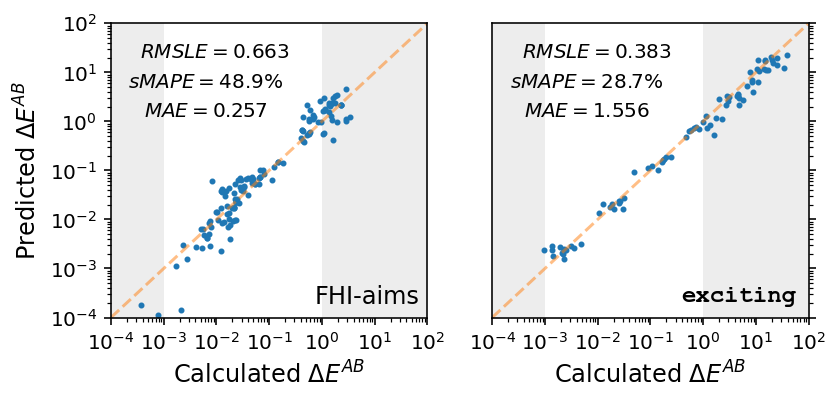

In [18]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
marker_size = 4
fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={"height_ratios": [1]})
# Create the true vs predicted plot for the stoichiometric model on FHI-aims data.
ax[0].plot(
    aims_result_df["aims_y_true"],
    aims_result_df["aims_stoichiometric"],
    ".",
    markersize=marker_size,
    alpha=1,
)

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(1e-4, 100)
ax[0].set_ylim(1e-4, 100)
ax[0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[0].set_xlabel("Calculated $\Delta E^{AB}$", fontsize=12)

ax[0].set_ylabel("Predicted $\Delta E^{AB}$", fontsize=12)

ax[0].minorticks_on()

ax[0].yaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[0].xaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[0].xaxis.set_minor_formatter(tck.NullFormatter())

ax[0].text(
    0.33,
    0.9,
    "$RMSLE=0.663$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
)
ax[0].text(
    0.3,
    0.8,
    "$sMAPE=48.9\%$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
)
ax[0].text(
    0.3,
    0.70,
    "$MAE=0.257$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
)
ax[0].text(
    0.81,
    0.07,
    "FHI-aims",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
    fontsize=12,
)

# Plot a 45 degree line which is the line where all data should lie if our model made perfect predictions.
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, "--", alpha=0.5)

# Create the true vs predicted plot for the stoichiometric model on exciting data.
ax[1].plot(
    exciting_result_df["exciting_y_true"],
    exciting_result_df["exciting_stoichiometric"],
    ".",
    markersize=marker_size,
    alpha=1,
)

# Use a log-log scale and set the ticks to be every order of magnitude.
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim(1e-4, 10)
ax[1].set_ylim(1e-4, 10)
ax[1].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)

ax[1].set_xlabel("Calculated $\Delta E^{AB}$", fontsize=12)

ax[1].minorticks_on()
ax[1].yaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[1].xaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[1].xaxis.set_minor_formatter(tck.NullFormatter())

ax[1].text(
    0.33,
    0.9,
    "$RMSLE=0.383$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
)
ax[1].text(
    0.3,
    0.8,
    "$sMAPE=28.7\%$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
)
ax[1].text(
    0.3,
    0.70,
    "$MAE=1.556$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
)
ax[1].text(
    0.78,
    0.07,
    "exciting",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
    fontname="Courier New",
    weight="bold",
    fontsize=12,
)

ax[1].yaxis.tick_right()
ax[1].tick_params(left=False)
ax[0].tick_params(right=False)
ax[1].set_yticklabels([])
# Create a 45 degree line where the data should lie if the model made perfect predictions.
x = np.linspace(*ax[0].get_xlim())
ax[1].plot(x, x, "--", alpha=0.5)
ax[0].set_facecolor("0.93")
ax[1].set_facecolor("0.93")

ax[0].axvspan(0.001, 1, facecolor="1", alpha=1)
ax[1].axvspan(0.001, 1, facecolor="1", alpha=1)

plt.tight_layout()
plt.show()

# Violin Plots of Percentage Errors

Let's now take a deeper look at the different errors the models produce. Specifically let's look at the distribution of absolute percentage errors of the different models. Violin plots in the following cells display the distributions of symmetric percentage errors (SPE) on the test data for all models. Violin plots combine kernel-density plots with box plots, where the latter shows the model’s SPE quantiles (5%, 25%, 50%, 75%, 95%). Outliers are plotted with dots above the respective 95% level. The kernel-density plots, underneath the box plots, provide estimates for the
probability-density for the SPE, e.g., they estimate the likelihood of the prediction errors in a given range when using the model.

In [19]:
# Make a new df where there's one column for the model
aims_violin_df = aims_result_df.copy().reset_index()
exciting_violin_df = exciting_result_df.copy().reset_index()

ape_stoich_aims =  100*np.divide(
    np.abs(aims_violin_df['aims_stoichiometric'] - aims_violin_df['aims_y_true']),
    0.5*np.abs(aims_violin_df['aims_stoichiometric']) + 0.5*np.abs(aims_violin_df['aims_y_true']))
ape_qrf_aims =  100*np.divide(
    np.abs(aims_violin_df['aims_qrf_prediction'] - aims_violin_df['aims_y_true']),
    0.5*np.abs(aims_violin_df['aims_qrf_prediction']) + 0.5*np.abs(aims_violin_df['aims_y_true']))
ape_combined_aims =  100*np.divide(
    np.abs(aims_violin_df['aims_sisso_prediction'] - aims_violin_df['aims_y_true']),
    0.5*np.abs(aims_violin_df['aims_sisso_prediction']) + 0.5*np.abs(aims_violin_df['aims_y_true']))


ape_stoich_exciting =  100*np.divide(
    np.abs(exciting_violin_df['exciting_stoichiometric'] - exciting_violin_df['exciting_y_true']),
    0.5*np.abs(exciting_violin_df['exciting_stoichiometric']) + 0.5*np.abs(exciting_violin_df['exciting_y_true']))
ape_qrf_exciting =  100*np.divide(
    np.abs(exciting_violin_df['exciting_qrf_prediction'] - exciting_violin_df['exciting_y_true']),
    0.5*np.abs(exciting_violin_df['exciting_qrf_prediction']) + 0.5*np.abs(exciting_violin_df['exciting_y_true']))
ape_combined_exciting =  100*np.divide(
    np.abs(exciting_violin_df['exciting_sisso_prediction'] - exciting_violin_df['exciting_y_true']),
    0.5*np.abs(exciting_violin_df['exciting_sisso_prediction']) + 0.5*np.abs(exciting_violin_df['exciting_y_true']))



# This code works to create a nested dataframe where the first key is the model we choose and the second
# is the metric. This is useful is we are curious in multiple metrics. At the moment we only use the
# symmetric absolute percentage error and it is a bit overkill.
model_df_aims = pd.DataFrame({})
for i in range(len(ape_qrf_aims)):
    df = {'model': 'QRF', 'ape': ape_qrf_aims[i],

         }
    model_df_aims = model_df_aims.append(df, ignore_index = True)
for i in range(len(ape_stoich_aims)):
    df = {
        'model': 'Stoichiometric', 'ape': ape_stoich_aims[i],
    }

    model_df_aims = model_df_aims.append(df, ignore_index = True)
for i in range(len(ape_combined_aims)):
    df = {
        'model': 'SISSO', 'ape': ape_combined_aims[i],
    }

    model_df_aims = model_df_aims.append(df, ignore_index = True)

model_df_exciting = pd.DataFrame({})
for i in range(len(ape_qrf_exciting)):
    df = {
        'model': 'QRF',
        'ape': ape_qrf_exciting[i],
    }
    model_df_exciting = model_df_exciting.append(df, ignore_index = True)
    
for i in range(len(ape_stoich_exciting)):
    df = {'model': 'Stoichiometric', 'ape': ape_stoich_exciting[i]
         }
    model_df_exciting = model_df_exciting.append(df, ignore_index = True)
for i in range(len(ape_combined_exciting)):
    df = {'model': 'SISSO', 'ape': ape_combined_exciting[i]
         }
    model_df_exciting = model_df_exciting.append(df, ignore_index = True)

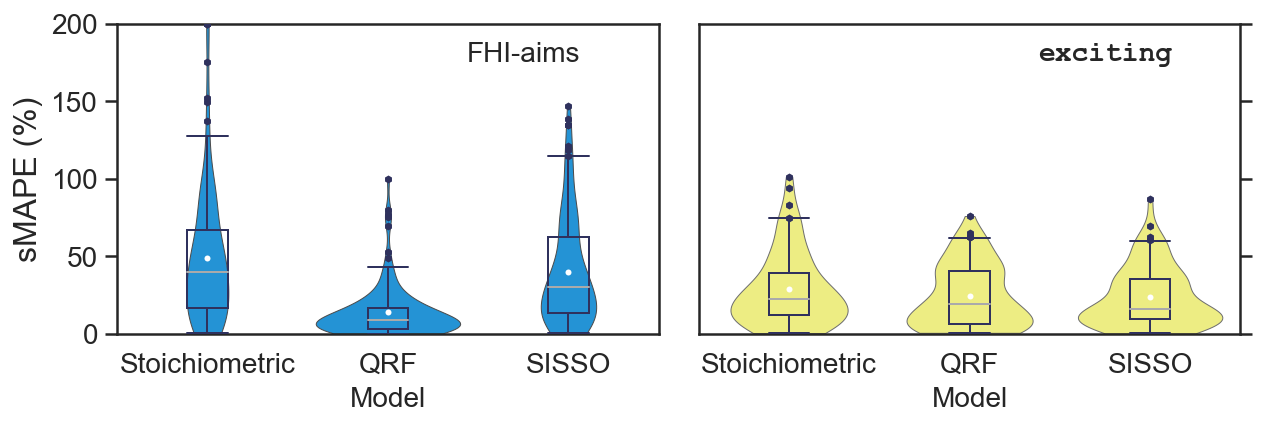

In [20]:
from matplotlib.patches import PathPatch
import seaborn as sns

sns.set(style="whitegrid")

def adjust_box_widths(ax, fac):
    """Adjust the widths of a seaborn-generated boxplot.

    Args:
        ax (matplotlib.pyplot.Axis): Axis to replot
        fac(float): Rescaling factor
    """
    # iterating through axes artists:
    for c in ax.get_children():

        # searching for PathPatches
        if isinstance(c, PathPatch):
            # getting current width of box:
            p = c.get_path()
            verts = p.vertices
            verts_sub = verts[:-1]
            xmin = np.min(verts_sub[:, 0])
            xmax = np.max(verts_sub[:, 0])
            xmid = 0.5 * (xmin + xmax)
            xhalf = 0.5 * (xmax - xmin)

            # setting new width of box
            xmin_new = xmid - fac * xhalf
            xmax_new = xmid + fac * xhalf
            verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
            verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

            # setting new width of median line
            for l in ax.lines:
                if np.all(l.get_xdata() == [xmin, xmax]):
                    l.set_xdata([xmin_new, xmax_new])

def plot_box(df, hue, color, marker, marker_sz, ax):
    sns.boxplot(
        data=df,
        x="model",
        y="ape",
        hue=hue,
        orient="v",
        palette=["#00035B"],
        boxprops={
            "zorder": 100, "linewidth": 1.0, "edgecolor": color,
            "facecolor":(1,0,0,0)},
            #"alpha":.3},
        whiskerprops={"zorder": 100, "color": color, "linewidth": 1.0},
        capprops={"zorder": 100, "color": color, "linewidth": 1.0},
        width=0.45,
        showmeans=True,
        whis=[0, 95],
        medianprops={"linewidth": 1.0, "color": "#AAAAAA", "zorder": 200},
        meanprops={
            "marker": "o",
            "markersize": 3.0,
            "markerfacecolor": "#FFFFFF",
            "markeredgewidth": 0.0,
            "zorder": 200,
        },
        flierprops={
            "marker": marker,
            "markersize": marker_sz,
            "markerfacecolor": color,
            "markeredgewidth": 0.0,
            "zorder": 200,
        },
        dodge=True,
        saturation=1.0,
        ax=ax,
        linewidth=10.5,
        order=['Stoichiometric', 'QRF', 'SISSO'],
    )

def plot_box_2(df, hue, color, marker, marker_sz, ax):
    sns.boxplot(
        data=df,
        x="model",
        y="ape",
        hue=hue,
        orient="v",
        palette=["#00035B"],
        boxprops={
            "zorder": 100, "linewidth": 1.0, "edgecolor": color,
            "facecolor":(1,0,0,0)},
            #"alpha":.3},
        whiskerprops={"zorder": 100, "color": color, "linewidth": 1.0},
        capprops={"zorder": 100, "color": color, "linewidth": 1.0},
        width=0.45,
        showmeans=True,
        whis=[0, 95],
        medianprops={"linewidth": 1.0, "color": "#AAAAAA", "zorder": 200},
        meanprops={
            "marker": "o",
            "markersize": 3.0,
            "markerfacecolor": "#FFFFFF",
            "markeredgewidth": 0.0,
            "zorder": 200,
        },
        flierprops={
            "marker": marker,
            "markersize": marker_sz,
            "markerfacecolor": color,
            "markeredgewidth": 0.0,
            "zorder": 200,
        },
        dodge=True,
        saturation=1.0,
        ax=ax,
        linewidth=1.5,
        order=['Stoichiometric', 'QRF', 'SISSO'],
    )
    

def plot_violin_1(df, hue, ax):
    sns.violinplot(
        data=df,
        x="model",
        y="ape",
        hue=hue,
        cut=0.0,
        inner=None,
        split=hue is not None,
        scale="area",
        palette = ["#069af3", "#069af3"],
        ax=ax,
        linewidth=0.5,
        order=['Stoichiometric', 'QRF', 'SISSO'],
    )
    
def plot_violin_2(df, hue, ax):
    sns.violinplot(
        data=df,
        x="model",
        y="ape",
        hue=hue,
        cut=0.0,
        inner=None,
        split=hue is not None,
        scale="area",
        palette=["#fffe71", "#fffe71"],
        ax=ax,
        linewidth=0.5,
        order=['Stoichiometric', 'QRF', 'SISSO'],
    )

sns.set(font_scale = 1.1)
sns.set_style(style='white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[9.0, 3.2])

ax1 = axs[0]
ax2 = axs[1]

plot_box(model_df_aims, None, "#2F315D", "h", 4, ax1)
# model_df_exciting_new = model_df_exciting.replace(['QRF'], 'Combined')
plot_box(model_df_exciting, None, "#2F315D", "h", 4, ax2)


# plot_box_2(model_df_exciting, None, "#2F315D", "h", 4, ax2)


plot_violin_1(model_df_aims, None, ax1)
plot_violin_2(model_df_exciting, None, ax2)

ax1.set_ylabel('sMAPE (%)', fontsize=16)
ax1.set_xlabel('Model', fontsize=14)

ax1.set_ylim(0, 200)
ax2.set_ylim(0, 200)
ax2.set_xlabel('Model', fontsize=14)
adjust_box_widths(ax1, 0.5) #If only one set 0.5 to 0.25
ax1.grid(False)

adjust_box_widths(ax2, .5) #If only one set 0.5 to 0.25
ax2.grid(False)


hfont = {'fontname':'Courier New'}
ax2.text(
    0.75, 0.9, 'exciting', horizontalalignment='center',
    verticalalignment='center', transform=ax2.transAxes, **hfont, weight="bold", fontsize=14)

ax1.text(
    0.75, 0.9, 'FHI-aims', horizontalalignment='center',
    verticalalignment='center', transform=ax1.transAxes, fontsize=14)

ax1.set_yticks([0, 50, 100, 150, 200])
ax2.set_yticklabels([])

ax2.set_ylabel('', fontsize=12)
ax1.tick_params(left=True)
ax2.tick_params(right=True)
ax2.tick_params(left=False)
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
ax1.yaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=14)
ax1.xaxis.set_tick_params(labelsize=14)
ax2.xaxis.set_tick_params(labelsize=14)

plt.tight_layout()
plt.show()

## Feature Importances

We know want to better understand our RF model by looking at what features helped us the most. We can calculate the gini feature importance which tells us which features when used as the splitting variable helped us decrease our optimizaiton metric the most on average.

aims columns
Index(['A_stoich_error (eV/atom)', 'B_EA_delta (eV)',
       'B_stoich_error (eV/atom)', 'binary_diff_basis_functions_pve',
       'B_rs (A)', 'B_IP_delta (eV)', 'A_EA_delta(eV)', 'A_IP_delta (eV)',
       'A_rs (A)'],
      dtype='object')
aims_importances
[0.59220919 0.18294365 0.09672106 0.05166155 0.03203093 0.02909207
 0.00693702 0.00429115 0.00411337]
exciting indices sorted
Index(['B_stoich_error (eV/atom)', 'precision_level',
       'A_stoich_error (eV/atom)', 'B_EA_delta (eV)', 'B_IP_delta (eV)',
       'B_rs (A)', 'A_EA_delta (eV)', 'A_rs (A)', 'A_IP_delta (eV)'],
      dtype='object')
exciting_importances
[0.48902296 0.28346041 0.17734822 0.01757403 0.0139294  0.00932208
 0.00358693 0.00316932 0.00258664]


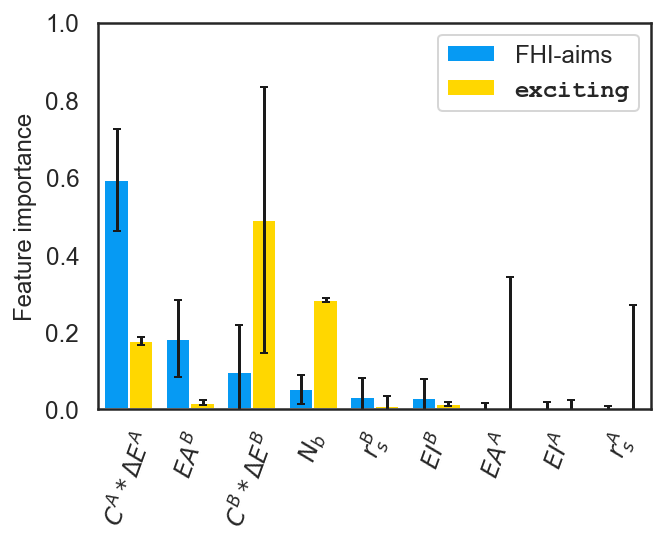

In [21]:
fig, ax = plt.subplots(
    1, 1, figsize=(4.8, 4), gridspec_kw={"height_ratios": [1]}
)  # , figsize=(6.5, 3,5))


aims_forest = aims_rando_for_gs.best_estimator_
aims_importances = aims_forest.feature_importances_

aims_std = np.std(
    [tree.feature_importances_ for tree in aims_forest.estimators_], axis=0
)
aims_indices = np.argsort(aims_importances)[::-1]

# Plot the feature importances of the forest
plt.bar(
    np.arange(9) - 0.20,
    aims_importances[aims_indices][0:9],
    yerr=aims_std[aims_indices][0:9],
    align="center",
    capsize=2,
    width=0.4,
    label="FHI-aims",
    color="#069af3",
)

ax.set_ylim(0, 1.0)

ax.set_ylabel("Feature importance", fontsize=12)
print("aims columns")
print(aims_X_train.columns[aims_indices])
print("aims_importances")
print(aims_importances[aims_indices])
ax.set_xticks((0, 1, 2, 3, 4, 5, 6, 7, 8))
# , (
ax.set_xticklabels(
    [
        "$C^{A}*\Delta E^{A}$",
        "$EA^{B}$",
        "$C^{B}*\Delta E^{B}$",
        "$N_b$",
        "$r_{s}^{B}$",
        "$EI^{B}$",
        "$EA^{A}$",
        "$EI^{A}$",
        "$r_{s}^{A}$",
    ],
    rotation="vertical",
    fontsize=12,
)

exciting_forest = exciting_rando_for_gs.best_estimator_
exciting_importances = exciting_forest.feature_importances_


exciting_std = np.std(
    [tree.feature_importances_ for tree in exciting_forest.estimators_], axis=0
)
exciting_indices = np.argsort(exciting_importances)[::-1]

print("exciting indices sorted")
print(exciting_X_train.columns[exciting_indices])
print("exciting_importances")
print(exciting_importances[exciting_indices])

reordered_indices = [2, 3, 0, 1, 5, 4, 8, 6, 7]

# Plot the feature importances of the forest
plt.bar(
    np.arange(9) + 0.2,
    exciting_importances[exciting_indices][reordered_indices],
    yerr=exciting_std[reordered_indices],
    align="center",
    capsize=2,
    label="exciting",
    width=0.4,
    color="gold",
)

plt.xticks(rotation=70)
leg = plt.legend(fontsize=12)

for i, text in enumerate(leg.get_texts()):
    # the element to be changed is in index position 0
    if i == 1:
        t = text.get_text()
        new_label = t
        text.set_fontname("Courier New")
        text.set_fontweight("bold")
plt.xlim([-0.5, 8.5])
plt.tight_layout()
plt.show()

# Prediction Intervals

We now return to our QRF models and look at the different trees in each forest model. The trees in the forest are by deisgn different from one another since the random forest model uses bootstrapping of the data and a random subset of variables for each split in the tree. To create quantiles, we simply look at the data that falls into each tree in our forest and look at the prediction for each one of those trees. For a given input data point, we can look at what leaf node that datapoint falls into for each tree in our forest, we then can build quantiles based on the values of the predictions from those leaf nodes for each tree in our forest. Specifically we look at 1%, 2.5%, 97.5% and 99% quantiles. We create our predition intervals by looking at the region between the 2.5% and 97.5% quantile which covers 95% of the spread and is therefore called the 95% prediction interval.

In [22]:
def fraction_in_prediction_intervals(df, quantile=0.025):
    """Get the fraction of datapoints that fall into the prediction intervals."""
    correct_num = 0
    total_num = 0
    for i in range(df.shape[0]):
        if df.loc[i, quantile] <= df.loc[i, "true"] <= df.loc[i, 1 - quantile]:
            correct_num += 1
        total_num += 1
    print(f"Correct number of data is {correct_num}")
    print(f"Total number of data {total_num}")
    print(f"Correct fraction {correct_num/total_num}")


aims_forest = aims_rando_for_gs.best_estimator_

aims_features_and_targets_df = aims_X_test.copy()
aims_features_and_targets_df["aims_y_test"] = aims_y_test.values


# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
quantiles_list = [0.01, 0.025, 0.05, 0.50, 0.95, 0.975, 0.99]
prediction_quantiles_df = pd.DataFrame()
for pred in aims_forest.estimators_:
    # For each tree in the forest get the predictions it makes for every
    # input data point.
    new_interval_temp_df = pd.Series(
        pred.predict(aims_features_and_targets_df.drop(columns=["aims_y_test"]))
    )
    # Concactenate horizontally, meaning add a new column to the dataframe for each
    # tree in the forest. This means the dataframe will have as many rows
    # as input data points and as many columns as trees in the forest.
    prediction_quantiles_df = pd.concat(
        [prediction_quantiles_df, new_interval_temp_df], axis=1
    )

RF_actual_pred = pd.DataFrame()
quantiles_list = [0.01, 0.025, 0.05, 0.50, 0.95, 0.975, 0.99]

for quantile in quantiles_list:
    # Get the quantiles for each row, meaning each row is treated as a different series
    # which is want we want since the columns represent different trees in our forest.
    interval = prediction_quantiles_df.quantile(q=quantile, axis=1)
    # Store this in a dataframe called RF_actual_pred, each row is a new datapoint.
    # Each column is a different prediction interval quantile.
    RF_actual_pred = pd.concat([RF_actual_pred, interval], axis=1, sort=False)


RF_actual_pred.columns = quantiles_list
RF_actual_pred["true"] = aims_features_and_targets_df["aims_y_test"].values

# s_df['aims_y_test'].values
chosen_quantile = 0.025
RF_actual_pred["interval"] = (
    RF_actual_pred[1 - chosen_quantile] - RF_actual_pred[chosen_quantile]
)
# Sort the dataframe by the true values.
aims_RF_actual_pred_sorted = RF_actual_pred.sort_values("true")
aims_RF_actual_pred_sorted = aims_RF_actual_pred_sorted.round(10)
aims_RF_actual_pred_sorted = aims_RF_actual_pred_sorted.reset_index()


aims_small_error_df = aims_features_and_targets_df.reset_index()
fraction_in_prediction_intervals(aims_RF_actual_pred_sorted)  # 0.9509

Correct number of data is 127
Total number of data 137
Correct fraction 0.927007299270073


## exciting Prediction Intervals

We perform the same operation as above but for the exciting data.

In [23]:
exciting_forest = exciting_rando_for_gs.best_estimator_

# Combine only the small (less than 1 eV atom errors with true values)

exciting_features_and_target_df = exciting_X_test.copy()
exciting_features_and_target_df["exciting_y_test"] = exciting_y_test.values


# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
quantiles_list = [0.01, 0.025, 0.05, 0.50, 0.95, 0.975, 0.99]
prediction_quantiles_df = pd.DataFrame()
for inference in exciting_forest.estimators_:
    new_interval_temp_df = pd.Series(
        inference.predict(
            exciting_features_and_target_df.drop(columns=["exciting_y_test"])
        )
    )
    prediction_quantiles_df = pd.concat(
        [prediction_quantiles_df, new_interval_temp_df], axis=1
    )


RF_actual_pred = pd.DataFrame()

for quantile in quantiles_list:
    interval = prediction_quantiles_df.quantile(q=quantile, axis=1)
    RF_actual_pred = pd.concat([RF_actual_pred, interval], axis=1, sort=False)

RF_actual_pred.columns = quantiles_list
RF_actual_pred["true"] = exciting_features_and_target_df["exciting_y_test"].values
chosen_quantile = 0.025
RF_actual_pred["interval"] = (
    RF_actual_pred[1 - chosen_quantile] - RF_actual_pred[chosen_quantile]
)
exciting_RF_actual_pred_sorted = RF_actual_pred.sort_values("true")
exciting_RF_actual_pred_sorted = exciting_RF_actual_pred_sorted.round(10)
exciting_RF_actual_pred_sorted = exciting_RF_actual_pred_sorted.reset_index()

fraction_in_prediction_intervals(exciting_RF_actual_pred_sorted)

Correct number of data is 67
Total number of data 78
Correct fraction 0.8589743589743589


## Plot Prediction Intervals

Here, we plot the prediction intervals of our different models against their true values. We plot the true values, the predicted values and the prediction intervals ontop of the predicted values for each data point in our test data set.

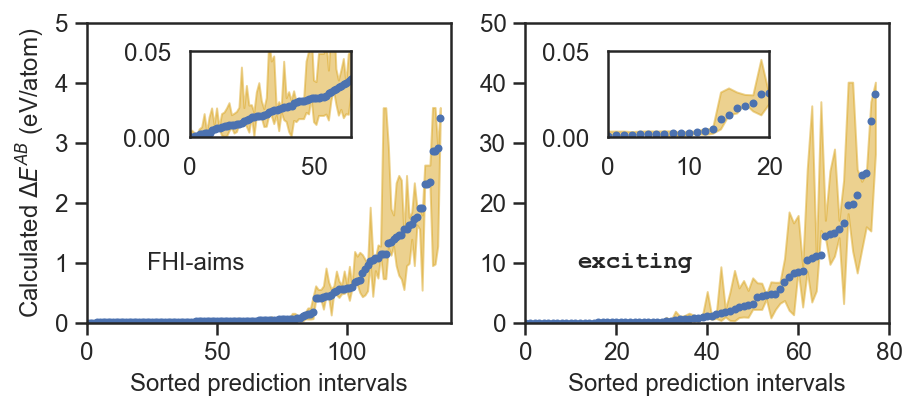

In [24]:
fig, ax = plt.subplots(
    1, 2, figsize=(6.6, 3), gridspec_kw={"height_ratios": [1]}
)  # , figsize=(6.5, 3,5))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.22, 0.65, 0.17, 0.2]

ax2 = fig.add_axes([left, bottom, width, height])

ax[0].plot(aims_RF_actual_pred_sorted["true"], "bo", markersize=3, label="true_values")
ax[0].fill_between(
    np.arange(aims_RF_actual_pred_sorted.shape[0]),
    aims_RF_actual_pred_sorted[chosen_quantile],
    aims_RF_actual_pred_sorted[1 - chosen_quantile],
    alpha=0.5,
    color="goldenrod",
    label="Predicted interval",
)
ax[0].set_xlabel("Sorted prediction intervals", fontsize=12)
ax[0].set_ylabel("Calculated $\Delta E^{AB}$ (eV/atom)", fontsize=12)

ax[0].set_ylim([0, 5])
ax[0].set_xlim([0, 140])

ax[0].set_yticks([0, 1, 2, 3, 4, 5], minor=False)


ax[1].plot(
    exciting_RF_actual_pred_sorted["true"], "bo", markersize=3, label="true_values"
)
ax[1].fill_between(
    np.arange(exciting_RF_actual_pred_sorted.shape[0]),
    exciting_RF_actual_pred_sorted[chosen_quantile],
    exciting_RF_actual_pred_sorted[1 - chosen_quantile],
    alpha=0.5,
    color="goldenrod",
    label="Predicted interval",
)
ax[1].set_xlabel("Sorted prediction intervals", fontsize=12)

ax[1].set_yticks([0, 10, 20, 30, 40, 50], minor=False)
ax[1].set_ylim([0, 50])
ax[1].set_xlim([0, 80])

ax2.plot(aims_RF_actual_pred_sorted["true"], "bo", markersize=3, label="true_values")
ax2.fill_between(
    np.arange(aims_RF_actual_pred_sorted.shape[0]),
    aims_RF_actual_pred_sorted[chosen_quantile],
    aims_RF_actual_pred_sorted[1 - chosen_quantile],
    alpha=0.5,
    color="goldenrod",
    label="Predicted interval",
)

ax2.set_xlim([0, 65])
ax2.set_ylim([0, 0.05])

left, bottom, width, height = [0.66, 0.65, 0.17, 0.2]

ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(
    exciting_RF_actual_pred_sorted["true"], "bo", markersize=3, label="true_values"
)
ax2.fill_between(
    np.arange(exciting_RF_actual_pred_sorted.shape[0]),
    exciting_RF_actual_pred_sorted[0.025],
    exciting_RF_actual_pred_sorted[0.975],
    alpha=0.5,
    color="goldenrod",
    label="Predicted interval",
)

ax2.set_xlim([0, 20])
ax2.set_ylim([0, 0.05])


ax[1].text(
    0.3,
    0.20,
    "exciting",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
    fontname="Courier New",
    weight="bold",
    fontsize=12,
)

ax[0].text(
    0.3,
    0.20,
    "FHI-aims",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
    fontsize=12,
)

ax[0].tick_params(bottom=True, top=False, left=True, right=False)
ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax[1].tick_params(bottom=True, top=False, left=True, right=False)
ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

plt.tight_layout()
plt.show()

## Plot the Prediction Intervals as a function of true energy errors

We can also look at how the prediction intervals size scale as a function of the true targets. We show this in a log-log scale plot since as mentioned earlier our data spans several orders of magnitude and we want to be able to visualize both the small and large test datapoints alike. We also print out the correlation between the size of the prediction itnervals and the DFT CBS energy correction targets.

exciting correlation between prediction interval sizes and true targets.
[[1.         0.72781133]
 [0.72781133 1.        ]]
FHI-aims correlation between prediction interval sizes and true targets.
[[1.         0.69348281]
 [0.69348281 1.        ]]


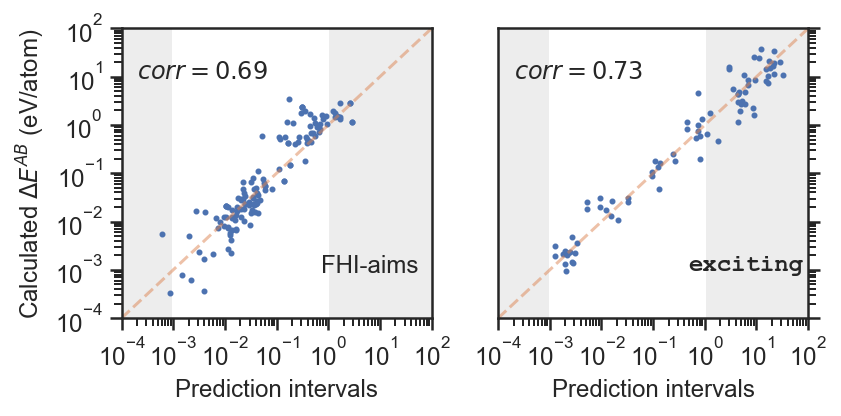

In [25]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

marker_size = 4

fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={"height_ratios": [1]})

ax[1].plot(
    exciting_RF_actual_pred_sorted[1 - chosen_quantile]
    - exciting_RF_actual_pred_sorted[chosen_quantile],
    exciting_RF_actual_pred_sorted["true"].values,
    ".",
    markersize=marker_size,
    alpha=1,
)

ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim(1e-4, 50)
ax[1].set_ylim(1e-4, 50)
ax[1].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)
ax[1].set_xlabel("Prediction intervals", fontsize=12)

ax[1].minorticks_on()

ax[1].yaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[1].xaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[1].xaxis.set_minor_formatter(tck.NullFormatter())

ax[1].text(
    0.8,
    0.18,
    "exciting",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
    fontname="Courier New",
    weight="bold",
    fontsize=12,
)
print("exciting correlation between prediction interval sizes and true targets.")
print(
    np.corrcoef(
        exciting_RF_actual_pred_sorted[1 - chosen_quantile]
        - exciting_RF_actual_pred_sorted[chosen_quantile],
        exciting_RF_actual_pred_sorted["true"].values,
    )
)

x = np.linspace(*ax[1].get_xlim())
ax[1].plot(x, x, "--", alpha=0.5)

ax[0].plot(
    aims_RF_actual_pred_sorted[1 - chosen_quantile]
    - aims_RF_actual_pred_sorted[chosen_quantile],
    aims_RF_actual_pred_sorted["true"].values,
    ".",
    markersize=marker_size,
    alpha=1,
)
print("FHI-aims correlation between prediction interval sizes and true targets.")
print(
    np.corrcoef(
        aims_RF_actual_pred_sorted[1 - chosen_quantile]
        - aims_RF_actual_pred_sorted[chosen_quantile],
        aims_RF_actual_pred_sorted["true"].values,
    )
)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(1e-4, 100)
ax[0].set_ylim(1e-4, 100)
ax[0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], minor=False)
ax[0].set_ylabel("Calculated $\Delta E^{AB}$ (eV/atom)", fontsize=12)
ax[0].set_xlabel("Prediction intervals", fontsize=12)

ax[0].minorticks_on()
ax[0].yaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[0].xaxis.set_minor_locator(
    tck.LogLocator(
        base=10,
        subs=[
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
            9.0,
        ],
        numticks=15,
    )
)
ax[0].xaxis.set_minor_formatter(tck.NullFormatter())

ax[1].text(
    0.26,
    0.85,
    "$corr=0.73$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[1].transAxes,
    fontsize=12,
)
ax[0].text(
    0.26,
    0.85,
    "$corr=0.69$",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
    fontsize=12,
)
ax[0].text(
    0.8,
    0.18,
    "FHI-aims",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax[0].transAxes,
    fontsize=12,
)

x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, "--", alpha=0.5)

ax[0].tick_params(bottom=True, top=False, left=True, right=False, which="both")
ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

ax[1].tick_params(bottom=True, top=False, left=False, right=True, which="both")
ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False)

ax[0].set_facecolor("0.93")
ax[1].set_facecolor("0.93")

ax[0].axvspan(0.001, 1, facecolor="1", alpha=1)
ax[1].axvspan(0.001, 1, facecolor="1", alpha=1)

plt.tight_layout()
plt.show()

# Conclusion

In this tutorial you've learned how machine learning methods can be used to perform CBS extrapolation of total energies. Specifically, we used the quantile random forest algorithm to perform inferences and the get prediction intervals. We analyzed the method's effective with respect to other models in the literature and also looked at how the model is built from the features and how it performs across the wide range of materials